In [ ]:
# Importing Libraries
 
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns #Plots
from matplotlib import rcParams #Size of plots  
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
# reading data
from pandas import read_hdf
df_final_train = read_hdf('storage_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_stage5.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'preff_att',
       'svd_dot_u', 'svd_dot_v'],
      dtype='object')

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
df_final_train, df_final_cv, y_train, y_cv = train_test_split(df_final_train, y_train, test_size=0.15, \
                                                              random_state=24, stratify=y_train)

In [ ]:
df_final_train.shape

(12835025, 55)

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
def save_hparam(hparam, hparam_name=None, fname='hyperparameters'):
    with open(fname+'.txt', 'a+') as file:
        if hparam_name is None:
            file.write('\n'+str(hparam))
        else:
            file.write('\n'+hparam_name+': '+str(hparam))

In [ ]:
# XGBoost Model

from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Hyperparameters
h_params = [[500, 1000, 1500, 2000],
            [3, 5],
            [0.001, 0.01, 0.1],
            [0.5, 0.75, 1],
            [0.5, 0.75, 1]]
# i = 0
#n_estimators = h_params[0]
best_n_estimators = None
# i = 1
#max_depth = h_params[1]
best_max_depth = None
# i = 2
#learning_rate = h_params[2]
best_learning_rate = None
# i = 3
#subsample = h_params[3]
best_subsample = None
# i = 4
#colsample_bytree = h_params[4]
best_colsample_bytree = None

for i in tqdm(range(5)):
    cv_scores = np.zeros_like(h_params[i])
    for j in tqdm(range(len(h_params[i]))):
        if i == 0:
            model_xgb = XGBClassifier(n_estimators = h_params[i][j], use_label_encoder=False, random_state=24, n_jobs=-1)
            model_xgb.fit(df_final_train, y_train)
            y_cv_pred = model_xgb.predict(df_final_cv)
            cv_scores[j] = f1_score(y_cv, y_cv_pred)
        elif i == 1:
            model_xgb = XGBClassifier(n_estimators = best_n_estimators, max_depth = h_params[i][j], \
                                      use_label_encoder=False, random_state=24, n_jobs=-1)
            model_xgb.fit(df_final_train, y_train)
            y_cv_pred = model_xgb.predict(df_final_cv)
            cv_scores[j] = f1_score(y_cv, y_cv_pred)
        elif i == 2:
            model_xgb = XGBClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, \
                                      learning_rate = h_params[i][j], use_label_encoder=False, random_state=24, n_jobs=-1)
            model_xgb.fit(df_final_train, y_train)
            y_cv_pred = model_xgb.predict(df_final_cv)
            cv_scores[j] = f1_score(y_cv, y_cv_pred)
        elif i == 3:
            model_xgb = XGBClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, \
                                      learning_rate = best_learning_rate, subsample = h_params[i][j], \
                                      use_label_encoder=False, random_state=24, n_jobs=-1)
            model_xgb.fit(df_final_train, y_train)
            y_cv_pred = model_xgb.predict(df_final_cv)
            cv_scores[j] = f1_score(y_cv, y_cv_pred)
        elif i == 4:
            model_xgb = XGBClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, \
                                      learning_rate = best_learning_rate, subsample = best_subsample, \
                                      colsample_bytree = h_params[i][j], use_label_encoder=False, random_state=24, n_jobs=-1)
            model_xgb.fit(df_final_train, y_train)
            y_cv_pred = model_xgb.predict(df_final_cv)
            cv_scores[j] = f1_score(y_cv, y_cv_pred)
    if i == 0:
        best_n_estimators = h_params[i][np.argmax(cv_scores)]
        #print(best_n_estimators)
        save_hparam(best_n_estimators, hparam_name='best_n_estimators')
    elif i == 1:
        best_max_depth = h_params[i][np.argmax(cv_scores)]
        save_hparam(best_max_depth, hparam_name='best_max_depth')
    elif i == 2:
        best_learning_rate = h_params[i][np.argmax(cv_scores)]
        save_hparam(best_learning_rate, hparam_name='best_learning_rate')
    elif i == 3:
        best_subsample = h_params[i][np.argmax(cv_scores)]
        save_hparam(best_subsample, hparam_name='best_subsample')
    elif i == 4:
        best_colsample_bytree = h_params[i][np.argmax(cv_scores)]
        save_hparam(best_colsample_bytree, hparam_name='best_colsample_bytree')

model_xgb = XGBClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, \
                          learning_rate = best_learning_rate, subsample = best_subsample, \
                          colsample_bytree = best_colsample_bytree, use_label_encoder=False, random_state=24, n_jobs=-1)
model_xgb.fit(df_final_train, y_train)

  0%|          | 0/4 [00:00<?, ?it/s]

[06:12:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**Best Hyperparameters:**

best_n_estimators = 500

best_max_depth = 3

best_learning_rate = 0.1

best_subsample = 0.75

best_colsample_bytree = 1

In [ ]:
# Training the model with best hyperparameters

from xgboost import XGBClassifier
from sklearn.metrics import f1_score

best_n_estimators = 500
best_max_depth = 3
best_learning_rate = 0.1
best_subsample = 0.75
best_colsample_bytree = 1

model_xgb = XGBClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, \
                          learning_rate = best_learning_rate, subsample = best_subsample, \
                          colsample_bytree = best_colsample_bytree, use_label_encoder=False, \
                          random_state=24, n_jobs=-1)

model_xgb.fit(df_final_train, y_train)

[12:42:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#with open('model_xgb1.pkl', 'wb') as file:
#    pickle.dump(model_xgb, file)

In [ ]:
y_train_pred = model_xgb.predict(df_final_train)
y_cv_pred = model_xgb.predict(df_final_cv)
y_test_pred = model_xgb.predict(df_final_test)
print('Train f1 score:', f1_score(y_train, y_train_pred))
print('CV f1 score:', f1_score(y_cv, y_cv_pred))
print('Test f1 score:', f1_score(y_test, y_test_pred))

Train f1 score: 0.9685590827835567
CV f1 score: 0.96857865494171
Test f1 score: 0.9040450074574066


Train confusion_matrix


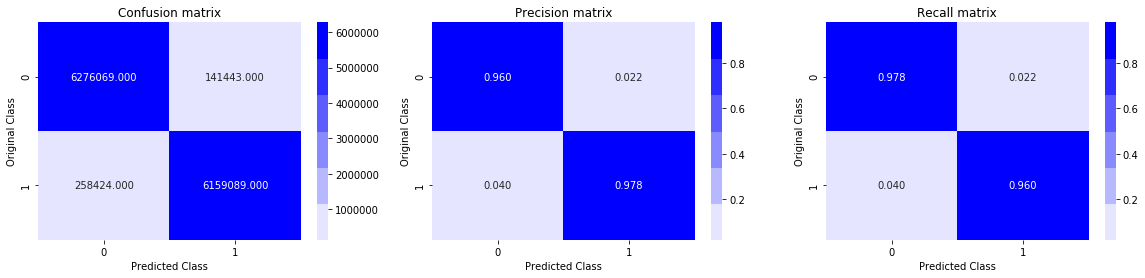


CV confusion_matrix


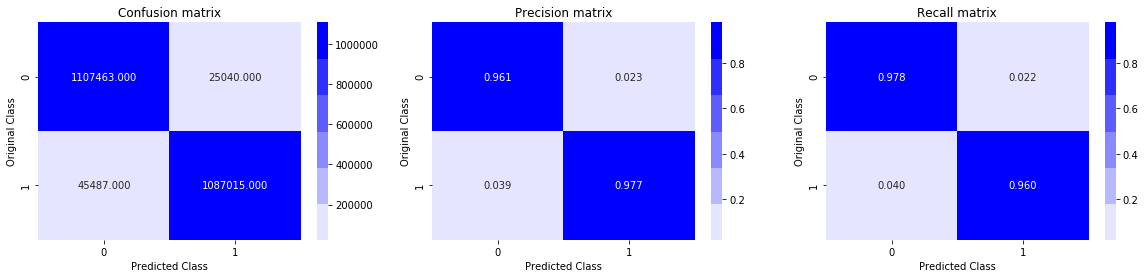


Test confusion_matrix


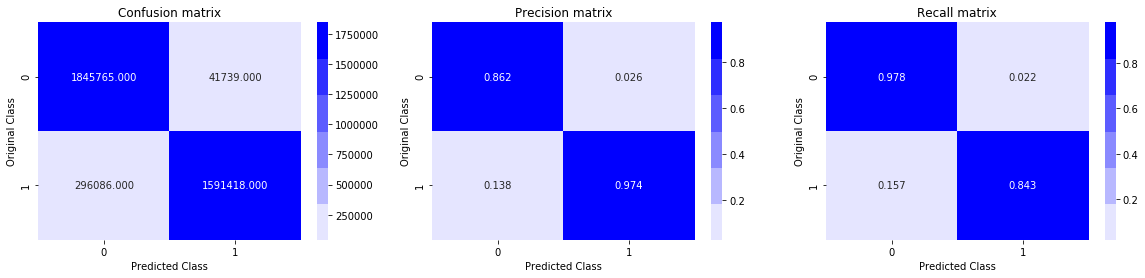

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train, y_train_pred)
print('\nCV confusion_matrix')
plot_confusion_matrix(y_cv, y_cv_pred)
print('\nTest confusion_matrix')
plot_confusion_matrix(y_test, y_test_pred)

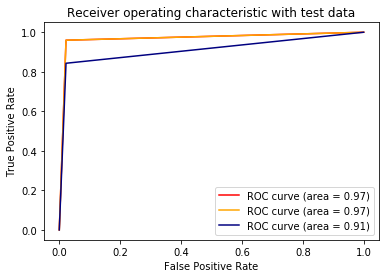

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_tr, tpr_tr, ths_tr = roc_curve(y_train, y_train_pred)
auc_tr = auc(fpr_tr, tpr_tr)

fpr_cv, tpr_cv, ths_cv = roc_curve(y_cv, y_cv_pred)
auc_cv = auc(fpr_cv, tpr_cv)

fpr_te, tpr_te, ths_te = roc_curve(y_test, y_test_pred)
auc_te = auc(fpr_te, tpr_te)

plt.plot(fpr_tr, tpr_tr, color='red', label='ROC curve (area = %0.2f)' % auc_tr)
plt.plot(fpr_tr, tpr_tr, color='orange', label='ROC curve (area = %0.2f)' % auc_cv)
plt.plot(fpr_te, tpr_te, color='navy',label='ROC curve (area = %0.2f)' % auc_te)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

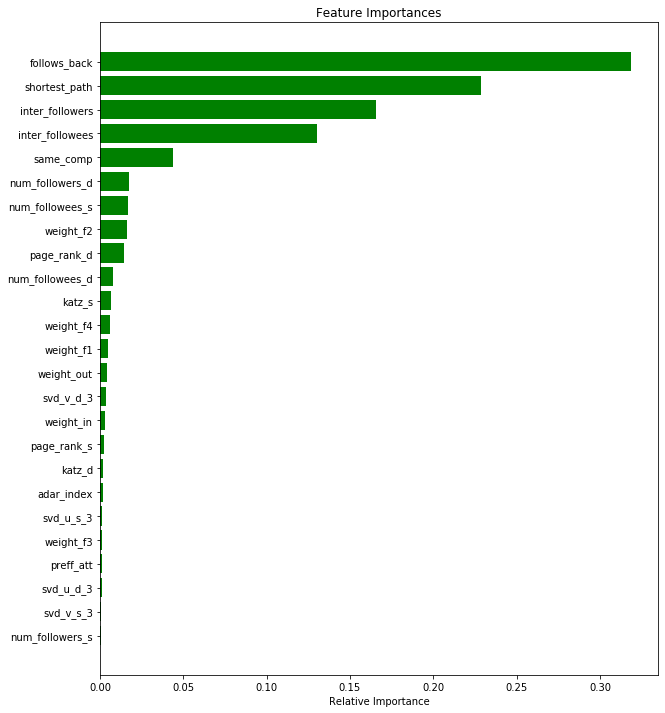

In [ ]:
features = df_final_train.columns
importances = model_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Conclusion:**

* Test f1 score is 0.9040 and Test AUC is 0.91
* The two new features, *preferential attachment* and *svd dot features*, do not have any significant impact on model performance.